In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [9]:
import pandas as pd
import numpy as np
import feather
import dask.array as da
import pyarrow.parquet as pq

In [2]:
import keras
import keras.backend as K
from keras.layers import LSTM,Dropout,Dense,TimeDistributed,Conv1D,MaxPooling1D,Flatten
from keras.models import Sequential
import tensorflow as tf
import gc
from numba import jit
from IPython.display import display, clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
sys.path.append('..')
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

import utils
import feature_extracter
from vsb_signal_dataset import VsbSignalDataset
from normalizer import Normalizer
from models import modelutils

Using TensorFlow backend.


In [5]:
batchsize = 128
sample_size = 800000
max_num = 127
min_num = -128
#n_dim = 160
window_size = 5000
stride = 5000

In [6]:
dataset = VsbSignalDataset(mode='train')

In [7]:
normalizer = Normalizer(min_num, max_num)
X = feature_extracter.feature_extracter(feature_extracter.time_feature_extracter,
                                        dataset, window_size=window_size, stride=stride, grouped=True, 
                                        normalizer=normalizer)

  0%|          | 0/4 [00:00<?, ?it/s]

2178


 25%|██▌       | 1/4 [02:30<07:31, 150.66s/it]

4356


 50%|█████     | 2/4 [04:42<04:49, 144.99s/it]

6534


 75%|███████▌  | 3/4 [06:53<02:20, 140.75s/it]

8712


100%|██████████| 4/4 [09:05<00:00, 138.09s/it]


In [7]:
testdata = VsbSignalDataset(mode='test')
X_test = feature_extracter.feature_extracter(feature_extracter.time_feature_extracter,
                                             testdata, window_size=window_size,
                                             stride=stride, grouped=True, 
                                             normalizer=normalizer)

  0%|          | 0/5 [00:00<?, ?it/s]

5082


 20%|██        | 1/5 [05:15<21:01, 315.29s/it]

10164


 40%|████      | 2/5 [10:29<15:45, 315.06s/it]

15246


 60%|██████    | 3/5 [15:43<10:29, 314.56s/it]

20328


 80%|████████  | 4/5 [20:55<05:13, 313.83s/it]

20337


100%|██████████| 5/5 [20:58<00:00, 220.60s/it]


In [8]:
np.save('X_time_feature.npy', X)
np.save('X_test_time_feature.npy', X_test)

In [10]:
X.shape
X_test.shape

(2904, 160, 57)

(6779, 160, 57)

In [11]:
data = np.concatenate([X, X_test])

In [12]:
data.shape

(9683, 160, 57)

In [13]:
y = np.concatenate([np.zeros(len(X)), np.ones(len(X_test))])

In [14]:
y.shape

(9683,)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(data, y, test_size=0.2, random_state=42,
                                                  stratify=y)

In [20]:
model = modelutils.get_model('bidirectional_lstm', X_train.shape)

In [24]:
batch_size=128
epoch=20
model_path = 'adversarial_validation_model.h5'
ckpt = ModelCheckpoint(model_path, save_best_only=True, 
                       save_weights_only=True, verbose=1, monitor='val_loss', mode='min')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, batch_size=batchsize, epochs=epoch, validation_data=[X_val, y_val], 
          callbacks=[ckpt])


Train on 7746 samples, validate on 1937 samples
Epoch 1/20
7746/7746 [==============================] - 63s 8ms/step - loss: 0.6218 - acc: 0.6989 - val_loss: 0.6111 - val_acc: 0.7001

Epoch 00001: val_loss improved from inf to 0.61114, saving model to adversarial_validation_model.h5
Epoch 2/20
7746/7746 [==============================] - 57s 7ms/step - loss: 0.6107 - acc: 0.7001 - val_loss: 0.6062 - val_acc: 0.7006

Epoch 00002: val_loss improved from 0.61114 to 0.60616, saving model to adversarial_validation_model.h5
Epoch 3/20
7746/7746 [==============================] - 56s 7ms/step - loss: 0.5955 - acc: 0.7038 - val_loss: 0.6010 - val_acc: 0.7114

Epoch 00003: val_loss improved from 0.60616 to 0.60103, saving model to adversarial_validation_model.h5
Epoch 4/20
7746/7746 [==============================] - 57s 7ms/step - loss: 0.5917 - acc: 0.7063 - val_loss: 0.5831 - val_acc: 0.7166

Epoch 00004: val_loss improved from 0.60103 to 0.58307, saving model to adversarial_validation_model

In [25]:
model.load_weights(model_path)

In [26]:
y_liketest = model.predict(X_val)

In [30]:
fpr, tpr, _ = metrics.roc_curve(y_val, y_liketest.flatten())
metrics.auc(fpr, tpr)

0.9016736985870155

In [33]:
data.shape
y.shape

(9683, 160, 57)

(9683,)

In [34]:
model_path = 'adversarial_validation_model.h5'
ckpt = ModelCheckpoint(model_path, save_best_only=True, 
                       save_weights_only=True, verbose=1, monitor='loss', mode='min')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(data, y, batch_size=batchsize, epochs=epoch, callbacks=[ckpt])

Epoch 1/20
9683/9683 [==============================] - 68s 7ms/step - loss: 0.3508 - acc: 0.8446

Epoch 00001: loss improved from inf to 0.35076, saving model to adversarial_validation_model.h5
Epoch 2/20
9683/9683 [==============================] - 67s 7ms/step - loss: 0.3279 - acc: 0.8524

Epoch 00002: loss improved from 0.35076 to 0.32794, saving model to adversarial_validation_model.h5
Epoch 3/20
9683/9683 [==============================] - 67s 7ms/step - loss: 0.3128 - acc: 0.8617

Epoch 00003: loss improved from 0.32794 to 0.31283, saving model to adversarial_validation_model.h5
Epoch 4/20
9683/9683 [==============================] - 66s 7ms/step - loss: 0.3076 - acc: 0.8669

Epoch 00004: loss improved from 0.31283 to 0.30760, saving model to adversarial_validation_model.h5
Epoch 5/20
9683/9683 [==============================] - 66s 7ms/step - loss: 0.2850 - acc: 0.8763

Epoch 00005: loss improved from 0.30760 to 0.28502, saving model to adversarial_validation_model.h5
Epoch 6/2

In [48]:
model.load_weights(model_path)
y_liketest = model.predict(X)

In [49]:
y_liketest

array([[0.04013635],
       [0.3329215 ],
       [0.00359937],
       ...,
       [0.0047981 ],
       [0.10642297],
       [0.03010849]], dtype=float32)

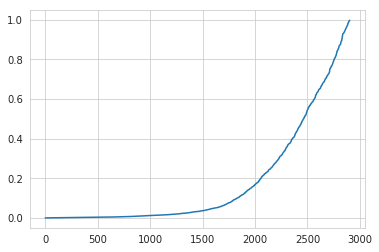

In [50]:
plt.plot(np.sort(y_liketest.flatten()))

In [60]:
val_group = np.argsort(y_liketest.flatten())[-290:]
train_group = np.argsort(y_liketest.flatten())[:-290]

In [56]:
len(val_group)
val_group

290

array([1838, 1532, 1171, 1123, 2826, 2532,  207, 1654, 1207, 1268, 2086,
        557,  668, 2583,  174, 2149,  204,  510, 1908, 1509, 1865, 1003,
       1158, 1853, 2172, 1058, 2039, 1554,   53, 1481,  975,  430,  878,
       1694, 2843,  353, 2365, 1955, 1627,  460,  269, 1379, 1859, 1671,
       1740, 1914,  966, 1653,  422, 1790, 1795, 1739, 2056,  495, 1826,
       2096, 2022, 2114, 2266, 1211, 1082, 2035, 1186,  592, 2171,  586,
       1426, 1423, 2023, 2807,  292, 2072, 1601, 1502,  789,  247, 1823,
       2191, 1733, 1994, 1101,   95, 2341, 1833,  962, 1836, 1844,  248,
        893,  873,  790, 2627, 2220,  575,  604, 2629, 2147, 2173, 2660,
       1803, 1230,  637, 2055, 2054, 1784, 2193, 1489, 1642, 2278, 2833,
        822,   78, 1930, 1011, 1485,  435, 2509, 2244, 1979, 1214, 1384,
       1249, 1189, 2394,  898, 1585, 2633, 2860, 1045, 2468, 2042,  301,
       2428,  159, 2897, 1656,  132, 1417,  792, 1899,  571, 1515,  968,
       1913,   79, 1682, 1987,  443, 2078,   40, 25

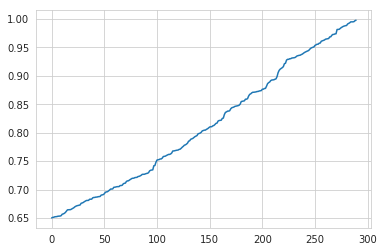

In [58]:
plt.plot(y_liketest[val_group])

In [59]:
np.save('adversrial_val_group.npy', val_group)

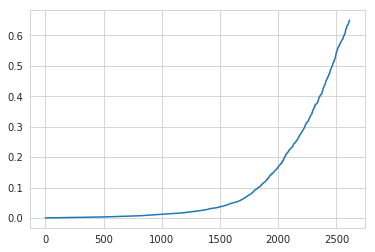

In [61]:
plt.plot(y_liketest[train_group])

In [62]:
np.save('adversarial_train_group.npy', train_group)

In [10]:
train_group = np.load('adversarial_train_group.npy')
val_group = np.load('adversarial_val_group.npy')

In [11]:
y = dataset.labels[::3]

In [12]:
y_train = y[train_group]
y_val = y[val_group]

In [13]:
np.sum(y_train)/len(y_train)
np.sum(y_val)/len(y_val)

0.06273909716908951

0.04827586206896552